In [2]:
import os
import torch
import numpy as np
import shutil
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


###############################################
#### Implement pytorch autoencoder on MNIST ###

# Define the encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 32, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 64, 7, 7]
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

    def forward(self, x):
        z = self.encoder(x)
        return z


# Define the decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 64, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 32, 28, 28]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),  # [batch_size, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.decoder(z)
        return x


# Combine encoder and decoder into an autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed


In [4]:
def extract_trainable_parameters(encoder):
    params_dict = {}
    
    for i, layer in enumerate(encoder.encoder):
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            params_dict[f'layer_{i}_weight'] = layer.weight.data.clone()
            params_dict[f'layer_{i}_bias'] = layer.bias.data.clone()
            
        elif isinstance(layer, nn.BatchNorm2d):
            # Only extract trainable parameters
            params_dict[f'layer_{i}_weight'] = layer.weight.data.clone()  # gamma
            params_dict[f'layer_{i}_bias'] = layer.bias.data.clone()      # beta

    return params_dict

# Example usage:
encoder = Encoder()
parameters = extract_trainable_parameters(encoder)

# Print the shapes of extracted parameters
for name, param in parameters.items():
    print(f"{name}: {param.shape}")

layer_0_weight: torch.Size([32, 1, 3, 3])
layer_0_bias: torch.Size([32])
layer_2_weight: torch.Size([32])
layer_2_bias: torch.Size([32])
layer_3_weight: torch.Size([32, 32, 3, 3])
layer_3_bias: torch.Size([32])
layer_5_weight: torch.Size([32])
layer_5_bias: torch.Size([32])


In [7]:
parameters['layer_0_bias']

tensor([-0.0237,  0.2226, -0.0311, -0.0018,  0.1320,  0.0812, -0.0407, -0.0391,
        -0.2267,  0.1007,  0.2777,  0.0497,  0.1388,  0.3078,  0.0735,  0.0951,
        -0.2551,  0.0549,  0.2309, -0.1667, -0.2303, -0.2065,  0.2092,  0.1215,
         0.2143,  0.2636,  0.2826,  0.0008,  0.2002, -0.2596,  0.0473, -0.1929])

In [9]:
encoder = Encoder()
for name, param in encoder.named_parameters():
    print(f"{name}: {param.shape}")

encoder.0.weight: torch.Size([32, 1, 3, 3])
encoder.0.bias: torch.Size([32])
encoder.2.weight: torch.Size([32])
encoder.2.bias: torch.Size([32])
encoder.3.weight: torch.Size([32, 32, 3, 3])
encoder.3.bias: torch.Size([32])
encoder.5.weight: torch.Size([32])
encoder.5.bias: torch.Size([32])


In [14]:
# Instantiate the autoencoder
autoencoder = Autoencoder()

print("Parameters for the Encoder and Decoder:")
for name, param in autoencoder.named_parameters():
    # Modify the name to remove the double 'encoder' or 'decoder' prefix
    name_parts = name.split('.')
    if name_parts[0] == 'encoder':
        # Remove the first 'encoder' and retain the rest
        name = '.'.join(name_parts[1:])
    elif name_parts[0] == 'decoder':
        # Remove the first 'decoder' and retain the rest
        name = '.'.join(name_parts[1:])
    
    # Print the modified name and shape
    print(name, list(param.shape))


Parameters for the Encoder and Decoder:
encoder.0.weight [32, 1, 3, 3]
encoder.0.bias [32]
encoder.2.weight [32]
encoder.2.bias [32]
encoder.3.weight [32, 32, 3, 3]
encoder.3.bias [32]
encoder.5.weight [32]
encoder.5.bias [32]
decoder.0.weight [32, 32, 3, 3]
decoder.0.bias [32]
decoder.2.weight [32]
decoder.2.bias [32]
decoder.3.weight [32, 32, 3, 3]
decoder.3.bias [32]
decoder.5.weight [32]
decoder.5.bias [32]
decoder.6.weight [32, 1, 3, 3]
decoder.6.bias [1]


In [5]:
# Instantiate the autoencoder
autoencoder = Autoencoder()

# Iterate over named parameters for the entire autoencoder
for name, param in autoencoder.named_parameters():
    print(name, list(param.shape))


encoder.encoder.0.weight [32, 1, 3, 3]
encoder.encoder.0.bias [32]
encoder.encoder.2.weight [32]
encoder.encoder.2.bias [32]
encoder.encoder.3.weight [32, 32, 3, 3]
encoder.encoder.3.bias [32]
encoder.encoder.5.weight [32]
encoder.encoder.5.bias [32]
decoder.decoder.0.weight [32, 32, 3, 3]
decoder.decoder.0.bias [32]
decoder.decoder.2.weight [32]
decoder.decoder.2.bias [32]
decoder.decoder.3.weight [32, 32, 3, 3]
decoder.decoder.3.bias [32]
decoder.decoder.5.weight [32]
decoder.decoder.5.bias [32]
decoder.decoder.6.weight [32, 1, 3, 3]
decoder.decoder.6.bias [1]


In [6]:
autoencoder = Autoencoder()

print("Children Layers of the Autoencoder:")
for name, child in autoencoder.named_children():
    print(f"{name}: {child}")
    
    # If you want to get layer-wise details for each child (e.g., encoder, decoder)
    for sub_name, sub_param in child.named_parameters():
        print(f"    {name}.{sub_name}: {sub_param.shape}")


Children Layers of the Autoencoder:
encoder: Encoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
    encoder.encoder.0.weight: torch.Size([32, 1, 3, 3])
    encoder.encoder.0.bias: torch.Size([32])
    encoder.encoder.2.weight: torch.Size([32])
    encoder.encoder.2.bias: torch.Size([32])
    encoder.encoder.3.weight: torch.Size([32, 32, 3, 3])
    encoder.encoder.3.bias: torch.Size([32])
    encoder.encoder.5.weight: torch.Size([32])
    encoder.encoder.5.bias: torch.Size([32])
decoder: Decoder(
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
   

In [9]:
def create_parameter_index_dict_CNN(layer_name, tensor_size, start_id):
    """
    Creates a dictionary mapping parameter IDs to their location indices and layer name,
    iterating from innermost to outermost dimension.
    
    Args:
        layer_name (str): Name of the layer (e.g., 'layer_0_weight')
        tensor_size (list): Size of the parameter tensor (e.g., [32, 1, 3, 3])
        start_id (int): Starting ID for indexing parameters
    
    Returns:
        dict: Dictionary mapping IDs to [location_indices, layer_name]
    """
    param_dict = {}
    current_id = start_id
    
    # Initialize indices
    indices = [0] * len(tensor_size)
    
    # Iterate through all dimensions from innermost to outermost
    for i0 in range(tensor_size[0]):        # outermost dimension
        indices[0] = i0
        for i1 in range(tensor_size[1]):
            indices[1] = i1
            for i2 in range(tensor_size[2]):
                indices[2] = i2
                for i3 in range(tensor_size[3]):  # innermost dimension
                    indices[3] = i3
                    param_dict[current_id] = [indices.copy(), layer_name]
                    current_id += 1
    
    return param_dict

# Example usage
if __name__ == "__main__":
    # Example parameters
    layer_name = "layer_0_weight"
    tensor_size = [64, 32, 3, 3]
    start_id = 0
    
    # Create the dictionary
    result = create_parameter_index_dict_CNN(layer_name, tensor_size, start_id)
    
    for key in result:
        print(key, result[key])

0 [[0, 0, 0, 0], 'layer_0_weight']
1 [[0, 0, 0, 1], 'layer_0_weight']
2 [[0, 0, 0, 2], 'layer_0_weight']
3 [[0, 0, 1, 0], 'layer_0_weight']
4 [[0, 0, 1, 1], 'layer_0_weight']
5 [[0, 0, 1, 2], 'layer_0_weight']
6 [[0, 0, 2, 0], 'layer_0_weight']
7 [[0, 0, 2, 1], 'layer_0_weight']
8 [[0, 0, 2, 2], 'layer_0_weight']
9 [[0, 1, 0, 0], 'layer_0_weight']
10 [[0, 1, 0, 1], 'layer_0_weight']
11 [[0, 1, 0, 2], 'layer_0_weight']
12 [[0, 1, 1, 0], 'layer_0_weight']
13 [[0, 1, 1, 1], 'layer_0_weight']
14 [[0, 1, 1, 2], 'layer_0_weight']
15 [[0, 1, 2, 0], 'layer_0_weight']
16 [[0, 1, 2, 1], 'layer_0_weight']
17 [[0, 1, 2, 2], 'layer_0_weight']
18 [[0, 2, 0, 0], 'layer_0_weight']
19 [[0, 2, 0, 1], 'layer_0_weight']
20 [[0, 2, 0, 2], 'layer_0_weight']
21 [[0, 2, 1, 0], 'layer_0_weight']
22 [[0, 2, 1, 1], 'layer_0_weight']
23 [[0, 2, 1, 2], 'layer_0_weight']
24 [[0, 2, 2, 0], 'layer_0_weight']
25 [[0, 2, 2, 1], 'layer_0_weight']
26 [[0, 2, 2, 2], 'layer_0_weight']
27 [[0, 3, 0, 0], 'layer_0_weight']
28

In [7]:
def calculate_position_from_id(layer_name, tensor_shape, start_id, query_id):
    """
    Calculate the position [n, c, h, w] in a tensor given a query ID.
    
    Args:
        layer_name (str): Name of the layer (not used in calculation but kept for consistency)
        tensor_shape (list): Shape of the tensor [N, C, H, W]
        start_id (int): Starting ID for the indexing
        query_id (int): The ID to convert to position
    
    Returns:
        list: Position [n, c, h, w] corresponding to the query_id
    """
    # First, adjust the query_id relative to start_id
    relative_id = query_id - start_id
    
    # Get dimensions
    N, C, H, W = tensor_shape
    
    # Calculate position
    # The order is from inner to outer dimension: W -> H -> C -> N
    w = relative_id % W
    h = (relative_id // W) % H
    c = (relative_id // (W * H)) % C
    n = (relative_id // (W * H * C)) % N
    
    return [n, c, h, w]

# Example usage and testing
if __name__ == "__main__":
    # Test parameters
    layer_name = "layer_0_weight"
    tensor_shape = [32, 1, 3, 3]
    start_id = 0
    
    # Test a few cases    
    position = calculate_position_from_id(layer_name, tensor_shape, start_id, 140)
    print(position)

[15, 0, 1, 2]


In [ ]:
def calculate_position_from_id(layer_name, tensor_shape, relative_id):
    """
    Calculate the position in a tensor given a query ID.
    
    Args:
        layer_name (str): Name of the layer (not used in calculation but kept for consistency)
        tensor_shape (list): Shape of the tensor [N, C, H, W] or [D] for one-dimensional tensors
        relative_id (int): relative parameter position
    
    Returns:
        list: Position corresponding to the query_id
    """
    # Use relative ID to locate the parameter position
    if len(tensor_shape) == 4:
        # Get dimensions for CNN layer
        N, C, H, W = tensor_shape
        # Calculate position
        # The order is from inner to outer dimension: W -> H -> C -> N
        w = relative_id % W
        h = (relative_id // W) % H
        c = (relative_id // (W * H)) % C
        n = (relative_id // (W * H * C)) % N
        return [n, c, h, w]
    elif len(tensor_shape) == 1:
        # Get dimension for one-dimensional tensor (e.g., bias or batch norm)
        D = tensor_shape[0]
        # Calculate position
        d = relative_id % D
        return [d]
    else:
        raise ValueError("Unsupported tensor shape: {}".format(tensor_shape))

    
# Example usage and testing
if __name__ == "__main__":
    # Test parameters
    layer_name = "layer_0_bias"
    tensor_shape = [32, 32, 3, 3]
    
    # Test a few cases    
    position = calculate_position_from_id(layer_name, tensor_shape, 2000-384)
    print(position)


[5, 19, 1, 2]


In [10]:
def update_parameter(model, layer_name, location, value):
    """
    Manually update a specific parameter in the autoencoder.
    
    Args:
        model (Autoencoder): The autoencoder model
        layer_name (str): Name of the layer (e.g., 'encoder.0.weight', 'decoder.5.bias')
        location (list or int): Parameter location. Can be [n,c,h,w] for conv weights or [c] for biases/BN
        value (float): New value to set
    
    Returns:
        bool: True if update successful, False otherwise
    """
    try:
        # Split the layer name to determine if it's in encoder or decoder
        main_module, *rest = layer_name.split('.')
        layer_index = int(rest[0])
        param_type = rest[1]
        
        # Select the appropriate module
        if main_module == 'encoder':
            module = model.encoder.encoder[layer_index]
        else:  # decoder
            module = model.decoder.decoder[layer_index]
            
        # Get the parameter tensor
        if param_type == 'weight':
            param_tensor = module.weight.data
        elif param_type == 'bias':
            param_tensor = module.bias.data
        else:
            raise ValueError(f"Unsupported parameter type: {param_type}")
            
        # Update the parameter
        if isinstance(location, list):
            param_tensor[tuple(location)] = value
        else:
            param_tensor[location] = value
            
        return True
        
    except Exception as e:
        print(f"Error updating parameter: {str(e)}")
        return False

# Example usage and testing
if __name__ == "__main__":
    # Create model
    model = Autoencoder()
    
    # Test cases
    test_cases = [
        # Encoder tests
        {
            'layer_name': 'encoder.0.weight',  # First conv layer weight
            'location': [15, 0, 2, 1],        # Specific kernel weight
            'value': 0.5
        },
        {
            'layer_name': 'encoder.0.bias',    # First conv layer bias
            'location': 15,                    # Channel 15 bias
            'value': 0.17
        },
        {
            'layer_name': 'encoder.2.weight',  # First BN layer gamma
            'location': 10,                    # Channel 10
            'value': 1.0
        },
        # Decoder tests
        {
            'layer_name': 'decoder.0.weight',  # First ConvTranspose weight
            'location': [20, 15, 1, 1],       # Specific kernel weight
            'value': 0.4
        },
        {
            'layer_name': 'decoder.2.bias',    # First BN layer beta
            'location': 5,                     # Channel 5
            'value': 0.1
        }
    ]
    
    # Run tests
    print("Testing parameter updates:")
    for test in test_cases:
        success = update_parameter(model, **test)
        if success:
            # Verify the update
            main_module, layer_idx, param_type = test['layer_name'].split('.')
            if main_module == 'encoder':
                module = model.encoder.encoder[int(layer_idx)]
            else:
                module = model.decoder.decoder[int(layer_idx)]
                
            param = getattr(module, param_type).data
            if isinstance(test['location'], list):
                actual_value = param[tuple(test['location'])].item()
            else:
                actual_value = param[test['location']].item()
                
            print(f"Updated {test['layer_name']} at {test['location']}")
            print(f"Expected: {test['value']}, Actual: {actual_value}")
            print("Success!" if abs(actual_value - test['value']) < 1e-6 else "Failed!")
        else:
            print(f"Failed to update {test['layer_name']}")
        print()

Testing parameter updates:
Updated encoder.0.weight at [15, 0, 2, 1]
Expected: 0.5, Actual: 0.5
Success!

Updated encoder.0.bias at 15
Expected: 0.17, Actual: 0.17000000178813934
Success!

Updated encoder.2.weight at 10
Expected: 1.0, Actual: 1.0
Success!

Updated decoder.0.weight at [20, 15, 1, 1]
Expected: 0.4, Actual: 0.4000000059604645
Success!

Updated decoder.2.bias at 5
Expected: 0.1, Actual: 0.10000000149011612
Success!



In [2]:
import math

values = [32, 64, 3, 3]
result = math.prod(values)
print(result)  # Output: 18432


18432


In [ ]:
import os
import torch
import numpy as np
import shutil
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from functools import reduce
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import defaultdict, Counter


#####################################
#### Network structure ##############
# Define the encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 32, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 64, 7, 7]
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

    def forward(self, x):
        z = self.encoder(x)
        return z


# Define the decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 64, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 32, 28, 28]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),  # [batch_size, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.decoder(z)
        return x


# Combine encoder and decoder into an autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed

In [ ]:
###############################
#### Parameter updating #######

#class function to obtain index for parameters
class ObtainIndexForParameters():
    '''
    The idea is:
    1. Obtain the layer name and shape of each layer.
    2. For each layer, obtain the original index range.
    3. Build index list for shuffle.
    4. In optimization, given an index, use index range to locate its layer and position.
    '''
    def __init__(self, autoencoder):

        self.autoencoder = autoencoder

    #obtain the layer name for encoder and decoder
    #also get the ID range for each layer
    #original index range:
    #Layer 1: ID1 to ID2
    #Layer 2: ID2+1 to ID3, etc.
    def obtain_layer_name(self):
        Dict = defaultdict()
        ID_s = 0
        for name, param in self.autoencoder.named_parameters():
            # Modify the name to remove the double 'encoder' or 'decoder' prefix
            name_parts = name.split('.')
            if name_parts[0] == 'encoder':
                # Remove the first 'encoder' and retain the rest
                name = '.'.join(name_parts[1:])
            elif name_parts[0] == 'decoder':
                # Remove the first 'decoder' and retain the rest
                name = '.'.join(name_parts[1:])
            
            List = list(param.shape)
            range = math.prod(List)
            Dict[name] = dict()
            Dict[name]['layer_shape'] = List
            Dict[name]['ID_range'] = [ID_s, ID_s + range - 1]
            ID_s += range

        #return both number of IDs and dictionary
        return(Dict, ID_s)

    #given an index, we will locate its corresponding layer.
    def locate_layer_by_id(self, layer_dict, ID):
        for name in layer_dict:
            if layer_dict[name]['ID_range'][0] <= ID <= layer_dict[name]['ID_range'][1]:
                return name
        raise ValueError('ID out of range: do not match the parameter number of the AE')

    def calculate_position_from_id(self, layer_name, tensor_shape, relative_id):
        """
        Calculate the position in a tensor given a query ID.
        
        Args:
            layer_name (str): Name of the layer (not used in calculation but kept for consistency)
            tensor_shape (list): Shape of the tensor [N, C, H, W] or [D] for one-dimensional tensors
            relative_id (int): relative parameter position
        
        Returns:
            list: Position corresponding to the query_id
        """
        # Use relative ID to locate the parameter position
        if len(tensor_shape) == 4:
            # Get dimensions for CNN layer
            N, C, H, W = tensor_shape
            # Calculate position
            # The order is from inner to outer dimension: W -> H -> C -> N
            w = relative_id % W
            h = (relative_id // W) % H
            c = (relative_id // (W * H)) % C
            n = (relative_id // (W * H * C)) % N
            return [n, c, h, w]
        elif len(tensor_shape) == 1:
            # Get dimension for one-dimensional tensor (e.g., bias or batch norm)
            D = tensor_shape[0]
            # Calculate position
            d = relative_id % D
            return [d]
        else:
            raise ValueError("Unsupported tensor shape: {}".format(tensor_shape))

    def locate_and_calculate_position(self, layer_dict, query_id):
        """
        Locate the layer and calculate the position in the tensor for a given ID.
        
        Args:
            layer_dict (dict): Dictionary containing layer information.
            query_id (int): The ID to locate and convert to position.
        
        Returns:
            tuple: (layer_name, position) corresponding to the query_id
        """
        # Locate the layer name using the query ID
        layer_name = self.locate_layer_by_id(layer_dict, query_id)
        
        # Get the ID range for the located layer
        start_id = layer_dict[layer_name]['ID_range'][0]
        # Calculate the actual ID within the layer's range
        relative_id = query_id - start_id
        
        # Calculate the position in the tensor
        tensor_shape = layer_dict[layer_name]['layer_shape']
        position = self.calculate_position_from_id(layer_name, tensor_shape, relative_id)
        
        return layer_name, position

    def get_parameter_value(self, layer_name, position):
        """
        Get the value of the parameter given the layer name and position.

        Args:
            layer_name (str): The name of the layer.
            position (list): The position of the parameter in the tensor.

        Returns:
            float: The value of the parameter at the specified position.
        """
        # Find the parameter tensor in the autoencoder
        for name, param in self.autoencoder.named_parameters():
            if name.endswith(layer_name):
                # Convert position list to a tuple for indexing
                pos_tuple = tuple(position)
                return param.data[pos_tuple].item()
        raise ValueError("Layer not found in the autoencoder: {}".format(layer_name))

    def set_parameter_value(self, layer_name, position, new_value):
        """
        Set the value of the parameter given the layer name and position.

        Args:
            layer_name (str): The name of the layer.
            position (list): The position of the parameter in the tensor.
            new_value (float): The new value to set.

        """
        # Find the parameter tensor in the autoencoder
        for name, param in self.autoencoder.named_parameters():
            if name.endswith(layer_name):
                # Convert position list to a tuple for indexing
                pos_tuple = tuple(position)
                param.data[pos_tuple] = new_value
                return
        raise ValueError("Layer not found in the autoencoder: {}".format(layer_name))


In [ ]:
# Example usage:
autoencoder = Autoencoder()
helper = ObtainIndexForParameters(autoencoder)
layer_dict, ID_s = helper.obtain_layer_name()

In [ ]:
for key in layer_dict:
    print(key, layer_dict[key])

In [ ]:
layer_name, position = helper.locate_and_calculate_position(layer_dict, 28321)
print(layer_name, position)

In [ ]:
value = helper.get_parameter_value(layer_name, position)
print("Parameter value at {} in {}: {}".format(position, layer_name, value))

In [ ]:
helper.set_parameter_value(layer_name, position, 0.5)
value_after = helper.get_parameter_value(layer_name, position)
print("Parameter value at {} in {} after update: {}".format(position, layer_name, value_after))

## New

In [4]:
import os
import torch
import numpy as np
import shutil
import math
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from functools import reduce
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import defaultdict, Counter


#####################################
#### Network structure ##############
# Define the encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 32, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 32, 7, 7]
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

    def quantize(self, z):
        # Quantization to 32 levels between 0 and 1
        z = torch.clamp(z, 0, 1)  # Ensure the values are between 0 and 1
        z_quantized = torch.round(z * 31) / 31  # Scale to 31, round, then scale back to [0, 1]
        return z_quantized

    def forward(self, x):
        z = self.encoder(x)
        z_quantized = self.quantize(z)
        return z_quantized


# Define the decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 64, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 32, 28, 28]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),  # [batch_size, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.decoder(z)
        return x


# Combine encoder and decoder into an autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed




###############################
#### Parameter updating #######

#class function to obtain index for parameters
class ObtainIndexForParameters():
    '''
    The idea is:
    1. Obtain the layer name and shape of each layer.
    2. For each layer, obtain the original index range.
    3. Build index list for shuffle.
    4. In optimization, given an index, use index range to locate its layer and position.
    '''
    def __init__(self, autoencoder):

        self.autoencoder = autoencoder

    #obtain the layer name for encoder and decoder
    #also get the ID range for each layer
    #original index range:
    #Layer 1: ID1 to ID2
    #Layer 2: ID2+1 to ID3, etc.
    def obtain_layer_name(self):
        Dict = defaultdict()
        ID_s = 0
        for name, param in self.autoencoder.named_parameters():
            # Modify the name to remove the double 'encoder' or 'decoder' prefix
            name_parts = name.split('.')
            if name_parts[0] == 'encoder':
                # Remove the first 'encoder' and retain the rest
                name = '.'.join(name_parts[1:])
            elif name_parts[0] == 'decoder':
                # Remove the first 'decoder' and retain the rest
                name = '.'.join(name_parts[1:])
            
            List = list(param.shape)
            range = math.prod(List)
            Dict[name] = dict()
            Dict[name]['layer_shape'] = List
            Dict[name]['ID_range'] = [ID_s, ID_s + range - 1]
            ID_s += range

        #return both number of IDs and dictionary
        return(Dict, ID_s)


#class function to update autoencoder parameters
class UpdateParameters():

    def __init__(self, autoencoder, layer_dict):

        self.autoencoder = autoencoder
        self.layer_dict = layer_dict

    #given an index, we will locate its corresponding layer.
    def locate_layer_by_id(self, ID):
        for name in self.layer_dict:
            if self.layer_dict[name]['ID_range'][0] <= ID <= self.layer_dict[name]['ID_range'][1]:
                return name
        raise ValueError('ID out of range: do not match the parameter number of the AE')

    def calculate_position_from_id(self, layer_name, tensor_shape, relative_id):
        """
        Calculate the position in a tensor given a query ID.
        
        Args:
            layer_name (str): Name of the layer (not used in calculation but kept for consistency)
            tensor_shape (list): Shape of the tensor [N, C, H, W] or [D] for one-dimensional tensors
            relative_id (int): relative parameter position
        
        Returns:
            list: Position corresponding to the query_id
        """
        # Use relative ID to locate the parameter position
        if len(tensor_shape) == 4:
            # Get dimensions for CNN layer
            N, C, H, W = tensor_shape
            # Calculate position
            # The order is from inner to outer dimension: W -> H -> C -> N
            w = relative_id % W
            h = (relative_id // W) % H
            c = (relative_id // (W * H)) % C
            n = (relative_id // (W * H * C)) % N
            return [n, c, h, w]
        elif len(tensor_shape) == 1:
            # Get dimension for one-dimensional tensor (e.g., bias or batch norm)
            D = tensor_shape[0]
            # Calculate position
            d = relative_id % D
            return [d]
        else:
            raise ValueError("Unsupported tensor shape: {}".format(tensor_shape))

    def locate_and_calculate_position(self, query_id):
        """
        Locate the layer and calculate the position in the tensor for a given ID.
        
        Args:
            layer_dict (dict): Dictionary containing layer information.
            query_id (int): The ID to locate and convert to position.
        
        Returns:
            tuple: (layer_name, position) corresponding to the query_id
        """
        # Locate the layer name using the query ID
        layer_name = self.locate_layer_by_id(query_id)
        
        # Get the ID range for the located layer
        start_id = self.layer_dict[layer_name]['ID_range'][0]
        # Calculate the actual ID within the layer's range
        relative_id = query_id - start_id
        
        # Calculate the position in the tensor
        tensor_shape = self.layer_dict[layer_name]['layer_shape']
        position = self.calculate_position_from_id(layer_name, tensor_shape, relative_id)
        
        return layer_name, position

    def get_parameter_value(self, layer_name, position):
        """
        Get the value of the parameter given the layer name and position.

        Args:
            layer_name (str): The name of the layer.
            position (list): The position of the parameter in the tensor.

        Returns:
            float: The value of the parameter at the specified position.
        """
        # Find the parameter tensor in the autoencoder
        for name, param in self.autoencoder.named_parameters():
            if name.endswith(layer_name):
                # Convert position list to a tuple for indexing
                pos_tuple = tuple(position)
                return param.data[pos_tuple].item()
        raise ValueError("Layer not found in the autoencoder: {}".format(layer_name))

    def set_parameter_value(self, layer_name, position, new_value):
        """
        Set the value of the parameter given the layer name and position.

        Args:
            layer_name (str): The name of the layer.
            position (list): The position of the parameter in the tensor.
            new_value (float): The new value to set.

        """
        # Find the parameter tensor in the autoencoder
        for name, param in self.autoencoder.named_parameters():
            if name.endswith(layer_name):
                # Convert position list to a tuple for indexing
                pos_tuple = tuple(position)
                param.data[pos_tuple] = new_value
                return
        raise ValueError("Layer not found in the autoencoder: {}".format(layer_name))

    def update_parameters_by_indices(self, indices, gamma):
        """
        Update the parameters corresponding to a list of indices.
        
        Args:
            indices (list): List of parameter indices to update.
            gamma (float): Threshold for random uniform number.
        
        Returns:
            autoencoder: The updated autoencoder model.
        """
        for query_k in indices:
            # Locate layer and position
            layer_name, position = self.locate_and_calculate_position(query_k)
            
            # Get current value
            value_k = self.get_parameter_value(layer_name, position)
            
            # Obtain random uniform number between (-gamma, gamma)
            kappa_k = random.uniform(-gamma, gamma)
            
            # Update parameter value
            self.set_parameter_value(layer_name, position, value_k + kappa_k)
        
        return self.autoencoder


In [5]:
# Initialize the autoencoder model
autoencoder = Autoencoder()

In [5]:
# Obtain the parameter dictionary and ID range
helper = ObtainIndexForParameters(autoencoder)
layer_dict, total_ids = helper.obtain_layer_name()

In [6]:
for key in layer_dict:
    print(key, layer_dict[key])

encoder.0.weight {'layer_shape': [32, 1, 3, 3], 'ID_range': [0, 287]}
encoder.0.bias {'layer_shape': [32], 'ID_range': [288, 319]}
encoder.2.weight {'layer_shape': [32], 'ID_range': [320, 351]}
encoder.2.bias {'layer_shape': [32], 'ID_range': [352, 383]}
encoder.3.weight {'layer_shape': [32, 32, 3, 3], 'ID_range': [384, 9599]}
encoder.3.bias {'layer_shape': [32], 'ID_range': [9600, 9631]}
encoder.5.weight {'layer_shape': [32], 'ID_range': [9632, 9663]}
encoder.5.bias {'layer_shape': [32], 'ID_range': [9664, 9695]}
decoder.0.weight {'layer_shape': [32, 32, 3, 3], 'ID_range': [9696, 18911]}
decoder.0.bias {'layer_shape': [32], 'ID_range': [18912, 18943]}
decoder.2.weight {'layer_shape': [32], 'ID_range': [18944, 18975]}
decoder.2.bias {'layer_shape': [32], 'ID_range': [18976, 19007]}
decoder.3.weight {'layer_shape': [32, 32, 3, 3], 'ID_range': [19008, 28223]}
decoder.3.bias {'layer_shape': [32], 'ID_range': [28224, 28255]}
decoder.5.weight {'layer_shape': [32], 'ID_range': [28256, 28287]

In [ ]:
# Instantiate the UpdateParameters class
updater = UpdateParameters(autoencoder, layer_dict)

# Update some parameters by indices
indices_to_update = [0, 100, 500, 1000]  # Example indices
gamma = 0.01

# Check if other parameters are the same
other_indices = [200, 300, 400]    


for query_id in indices_to_update:
    layer_name, position = updater.locate_and_calculate_position(query_id)
    value = updater.get_parameter_value(layer_name, position)
    print(f"Parameter at index {query_id} ({layer_name}, {position}): {value}")

for query_id in other_indices:
    layer_name, position = updater.locate_and_calculate_position(query_id)
    value = updater.get_parameter_value(layer_name, position)
    print(f"Parameter at index {query_id} ({layer_name}, {position}): {value}")


In [ ]:
updated_autoencoder = updater.update_parameters_by_indices(indices_to_update, gamma)

In [ ]:
for query_id in indices_to_update:
    layer_name, position = updater.locate_and_calculate_position(query_id)
    value = updater.get_parameter_value(layer_name, position)
    print(f"Parameter at index {query_id} ({layer_name}, {position}): {value}")

for query_id in other_indices:
    layer_name, position = updater.locate_and_calculate_position(query_id)
    value = updater.get_parameter_value(layer_name, position)
    print(f"Parameter at index {query_id} ({layer_name}, {position}): {value}")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a function to count non-zero dimensions in each (num_filter, h, w) tensor
def count_non_zero_dimensions(encoder_output):
    # Count non-zero values in each (num_filter, h, w) tensor along the channel axis
    batch_size = encoder_output.shape[0]
    non_zero_count = []
    for i in range(batch_size):
        non_zero_dims = torch.sum(encoder_output[i] != 0, dim=(1, 2))  # Count non-zero values for each channel (dim 1)
        total_non_zero = torch.sum(non_zero_dims)  # Sum across all channels to get total non-zero values
        non_zero_count.append(total_non_zero.item())
    return non_zero_count

# Define a function to calculate the information captured by the reconstructed images
# based on pixel differences with a tolerance threshold
def calculate_information_captured(original_batch, reconstructed_batch):
    # Ensure the pixel values are between 0 and 255 (assuming input is in range [0, 1])
    original_batch = torch.clamp((original_batch * 255).round(), 0, 255).int()
    reconstructed_batch = torch.clamp((reconstructed_batch * 255).round(), 0, 255).int()

    # Calculate the pixel-wise difference
    difference = torch.abs(original_batch - reconstructed_batch)

    # Apply the information formula for d <= K, otherwise set information captured to 0
    information_captured = torch.where(difference <= 7, torch.log2(256 / (2 * difference + 1)), torch.tensor(0.0))

    # Sum over all pixels (28 * 28) for each image in the batch
    total_information_captured = torch.sum(information_captured, dim=(1, 2, 3))

    # Convert to list and return
    return total_information_captured.tolist()

# Example usage
autoencoder = Autoencoder()  # Assuming the autoencoder is defined as per the previous implementation

# Generate a sample input and get the output from the encoder
sample_input = torch.randn((2, 1, 28, 28))  # Batch size of 2
encoder_output = autoencoder.encoder(sample_input)  # Output shape: [batch_size, 32, 7, 7]

# Count non-zero dimensions in each (32, 7, 7) tensor
non_zero_count = count_non_zero_dimensions(encoder_output)
print(non_zero_count)


NameError: name 'Autoencoder' is not defined

In [6]:
import torch
import numpy as np
import torch.nn as nn

# Define a class to calculate encoder non-zero dimensions and information captured
class AutoencoderEvaluator:
    def __init__(self, autoencoder, alpha=0.1):
        self.autoencoder = autoencoder
        self.alpha = alpha

    def count_non_zero_dimensions(self, encoder_output):
        # Count non-zero values in each (num_filter, h, w) tensor along the channel axis
        batch_size = encoder_output.shape[0]
        non_zero_count = []
        zero_count = []
        for i in range(batch_size):
            non_zero_dims = torch.sum(encoder_output[i] != 0, dim=(1, 2))  # Count non-zero values for each channel (dim 1)
            total_non_zero = torch.sum(non_zero_dims)  # Sum across all channels to get total non-zero values
            total_zero = encoder_output[i].numel() - total_non_zero  # Total elements minus non-zero elements
            non_zero_count.append(total_non_zero.item())
            zero_count.append(total_zero.item())
        return non_zero_count, zero_count

    def calculate_information_captured(self, original_batch, reconstructed_batch):
        # Ensure the pixel values are between 0 and 255 (assuming input is in range [0, 1])
        original_batch = torch.clamp((original_batch * 255).round(), 0, 255).int()
        reconstructed_batch = torch.clamp((reconstructed_batch * 255).round(), 0, 255).int()

        # Calculate the pixel-wise difference
        difference = torch.abs(original_batch - reconstructed_batch)

        # Apply the information formula for d <= 7, otherwise set information captured to 0
        information_captured = torch.where(difference <= 7, torch.log2(256 / (2 * difference + 1)), torch.tensor(0.0))

        # Sum over all pixels (28 * 28) for each image in the batch
        total_information_captured = torch.sum(information_captured, dim=(1, 2, 3))

        # Convert to list and return
        return total_information_captured.tolist()

    def evaluate_batch(self, batch):
        # Obtain the encoder output and reconstructed images
        encoder_output = self.autoencoder.encoder(batch)
        reconstructed_output = self.autoencoder(batch)

        # Calculate non-zero and zero dimensions in encoder output
        non_zero_count, zero_count = self.count_non_zero_dimensions(encoder_output)

        # Calculate the information captured in the reconstructed images
        information_captured = self.calculate_information_captured(batch, reconstructed_output)

        # Calculate the final score for each sample in the batch
        batch_scores = []
        for i in range(len(information_captured)):
            score = (information_captured[i] / (non_zero_count[i]+0.001) ) + self.alpha * zero_count[i]
            batch_scores.append(score)

        # Sum over all sample scores to get the final batch score
        final_score = sum(batch_scores)/len(information_captured)
        return final_score

# Example usage
autoencoder = Autoencoder()  # Assuming the autoencoder is defined as per the previous implementation
evaluator = AutoencoderEvaluator(autoencoder, alpha=0.01)

# Generate a sample input
sample_input = torch.rand((100, 1, 28, 28))  # Batch size of 2

# Evaluate the batch
final_score = evaluator.evaluate_batch(sample_input)
print(final_score)


10.793753082926623


In [8]:
import torch
import numpy as np
import torch.nn as nn

# Define a class to calculate encoder non-zero dimensions and information captured
class AutoencoderEvaluator:
    def __init__(self, alpha=0.1):
        self.alpha = alpha

    def count_non_zero_dimensions(self, encoder_output):
        # Count non-zero values in each (num_filter, h, w) tensor along the channel axis
        batch_size = encoder_output.shape[0]
        non_zero_count = []
        zero_count = []
        for i in range(batch_size):
            non_zero_dims = torch.sum(encoder_output[i] != 0, dim=(1, 2))  # Count non-zero values for each channel (dim 1)
            total_non_zero = torch.sum(non_zero_dims)  # Sum across all channels to get total non-zero values
            total_zero = encoder_output[i].numel() - total_non_zero  # Total elements minus non-zero elements
            non_zero_count.append(total_non_zero.item())
            zero_count.append(total_zero.item())
        return non_zero_count, zero_count

    def calculate_information_captured(self, original_batch, reconstructed_batch):
        # Ensure the pixel values are between 0 and 255 (assuming input is in range [0, 1])
        original_batch = torch.clamp((original_batch * 255).round(), 0, 255).int()
        reconstructed_batch = torch.clamp((reconstructed_batch * 255).round(), 0, 255).int()

        # Calculate the pixel-wise difference
        difference = torch.abs(original_batch - reconstructed_batch)

        # Apply the information formula for d <= 7, otherwise set information captured to 0
        information_captured = torch.where(difference <= 7, torch.log2(256 / (2 * difference + 1)), torch.tensor(0.0))

        # Sum over all pixels (28 * 28) for each image in the batch
        total_information_captured = torch.sum(information_captured, dim=(1, 2, 3))

        # Convert to list and return
        return total_information_captured.tolist()

    def evaluate_batch(self, encoder_output, original_batch, reconstructed_output):
        # Calculate non-zero and zero dimensions in encoder output
        non_zero_count, zero_count = self.count_non_zero_dimensions(encoder_output)

        # Calculate the information captured in the reconstructed images
        information_captured = self.calculate_information_captured(original_batch, reconstructed_output)

        # Calculate the final score for each sample in the batch
        batch_scores = []
        for i in range(len(information_captured)):
            score = (information_captured[i] / (non_zero_count[i] + 0.001)) + self.alpha * zero_count[i]
            batch_scores.append(score)

        # Sum over all sample scores to get the final batch score
        final_score = sum(batch_scores) / len(information_captured)
        return final_score

# Example usage
autoencoder = Autoencoder()  # Assuming the autoencoder is defined as per the previous implementation
encoder = autoencoder.encoder

# Generate a sample input
sample_input = torch.rand((2, 1, 28, 28))  # Batch size of 2
encoder_output = encoder(sample_input)
reconstructed_output = autoencoder(sample_input)  # Reconstructed images

# Create an evaluator instance
evaluator = AutoencoderEvaluator(alpha=0.01)

# Evaluate the batch
final_score = evaluator.evaluate_batch(encoder_output, sample_input, reconstructed_output)
print(final_score)


10.78580585989505


/tmp/ipykernel_23818/2885063932.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder = torch.load(pth_path)


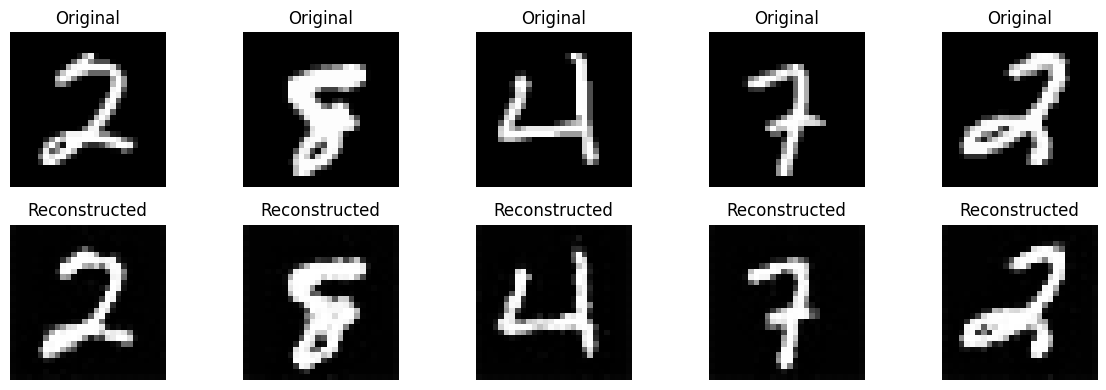

Final Compression Rate Score: 0.0
Information Original: [1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 1237.3543701171875, 123

In [88]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 32, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 32, 7, 7]
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

    def quantize(self, z):
        # Quantization to 32 levels between 0 and 1
        z = torch.clamp(z, 0, 1)  # Ensure the values are between 0 and 1
        z_quantized = torch.round(z * 31) / 31  # Scale to 31, round, then scale back to [0, 1]
        return z_quantized

    def forward(self, x):
        z = self.encoder(x)
        z_quantized = self.quantize(z)
        return z_quantized


# Define the decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 64, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 32, 28, 28]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),  # [batch_size, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.decoder(z)
        return x


# Combine encoder and decoder into an autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed


# Define a class to calculate encoder non-zero dimensions and information captured
class AutoencoderEvaluator:
    def __init__(self, alpha, M):
        # the final return is:
        # captured information * alpha + compression_rate
        # We may keep alpha = 0 for just focus on compression rate
        self.alpha = alpha
        self.M = M

    #we may or may not use this func !!!!!
    def count_non_zero_dimensions(self, encoder_output):
        # Count non-zero values in each (num_filter, h, w) tensor along the channel axis
        batch_size = encoder_output.shape[0]
        non_zero_count = []
        zero_count = []
        for i in range(batch_size):
            non_zero_dims = torch.sum(encoder_output[i] != 0, dim=(1, 2))  # Count non-zero values for each channel (dim 1)
            total_non_zero = torch.sum(non_zero_dims)  # Sum across all channels to get total non-zero values
            total_zero = encoder_output[i].numel() - total_non_zero  # Total elements minus non-zero elements
            non_zero_count.append(total_non_zero.item())
            zero_count.append(total_zero.item())
        return non_zero_count, zero_count

    def calculate_information(self, encoder_output, num_bins=32):
        """
        Calculate the amount of information required to describe a one-channel image pixel by pixel.

        Args:
            encoder_output (torch.Tensor): The output of the encoder with shape (batch_size, num_filters, h', w').
            num_bins (int): The number of quantized levels (default is 32).

        Returns:
            information_list (list): A list where each element is the total information for a batch sample.
        """
        batch_size, num_filters, h_prime, w_prime = encoder_output.shape

        # Initialize a tensor to store information per pixel for each batch
        pixelwise_information = torch.zeros(batch_size, h_prime, w_prime, device=encoder_output.device)

        for h in range(h_prime):
            for w in range(w_prime):
                # Extract values at the same spatial location (h, w) across the batch and all filters
                pixel_values = encoder_output[:, :, h, w].flatten()  # Shape: (batch_size * num_filters,)

                # Scale values to [0, num_bins - 1] and quantize
                quantized_indices = (pixel_values * (num_bins - 1)).round().to(torch.int64)

                # Calculate histogram to get counts of each quantized value
                histogram = torch.bincount(quantized_indices, minlength=num_bins).float()

                # Calculate probabilities for each quantized value
                total_elements = pixel_values.numel()
                probabilities = histogram / total_elements

                # Avoid log(0) by masking zero probabilities
                probabilities[probabilities == 0] = 1e-12

                # Compute -log2(probabilities)
                log_probabilities = -torch.log2(probabilities)

                # Calculate pixel-wise information for the current (h, w)
                pixel_quantized_indices = (encoder_output[:, :, h, w] * (num_bins - 1)).round().to(torch.int64)
                batch_histogram = torch.bincount(pixel_quantized_indices.flatten(), minlength=num_bins).float()

                # Compute total information for this pixel
                pixel_information = torch.sum(batch_histogram * log_probabilities)

                # Assign information to each batch sample
                pixelwise_information[:, h, w] = pixel_information / batch_size

        # Sum over all pixels to get total information for each batch sample
        total_information_per_sample = pixelwise_information.sum(dim=(1, 2)).tolist()

        return total_information_per_sample


    def evaluate_batch(self, encoder_output, original_images, reconstructed_images):
        """
        Compute the information compression rate of the autoencoder.

        Args:
            encoder_output (torch.Tensor): Encoder output with shape (batch_size, num_filters, h', w').
            original_images (torch.Tensor): Original images with shape (batch_size, 1, H, W).
            reconstructed_images (torch.Tensor): Reconstructed images with shape (batch_size, 1, H, W).

        Returns:
            float: The final compression rate score.
        """

        # Threshold residual image values
        #reconstructed_images[reconstructed_images <= 0.04] = 0.
        #reconstructed_images[reconstructed_images >= 0.96] = 1.

        # Calculate information in original images
        information_original = self.calculate_information(original_images, num_bins=256)

        # Calculate information in encoder output
        information_encoder = self.calculate_information(encoder_output, num_bins=32)

        # Compute residual images
        residual_images = original_images - reconstructed_images

        # Normalize residual images to range [0, 1]
        residual_images = (residual_images + 1) / 2

        # Calculate information in residual images
        information_residual = self.calculate_information(residual_images, num_bins=512)

        # Calculate information obtained by reconstruction
        information_reconstruct = [max(0, orig - resid) for orig, resid in zip(information_original, information_residual)]

        # Calculate compression rate for each batch
        compress_batch = [reconstruct / (encoder + 1e-12) for reconstruct, encoder in zip(information_reconstruct, information_encoder)]

        # Sort and take the top M compression rates
        top_compression_rates = sorted(compress_batch, reverse=True)[:self.M]

        # Return the final compression rate score
        final_score = sum(top_compression_rates)
        return final_score, information_original, information_residual, information_reconstruct, information_encoder


# Function to load the autoencoder and evaluate
def load_and_evaluate_autoencoder(pth_path, batch_size=10, 
                                  dataset_path='../../data/MNIST/', 
                                  alpha=0):
    """
    Load a saved autoencoder model and evaluate it using the provided evaluation function.

    Args:
        pth_path (str): Path to the .pth file containing the autoencoder.
        batch_size (int): Batch size for evaluation.
        dataset_path (str): Path to the MNIST dataset.
        alpha (float): Weight for the information captured term in evaluation.
        M (int): Number of top compression rates to consider in evaluation.

    Returns:
        float: Final compression rate score for the autoencoder.
        Additional intermediate metrics: information_original, information_residual, 
        information_reconstruct, information_encoder.
    """
    # Initialize a new Autoencoder instance
    autoencoder = Autoencoder()

    # Load the saved weights
    autoencoder = torch.load(pth_path)
    autoencoder = autoencoder.to('cuda')
    autoencoder.eval()  # Set the model to evaluation mode

    # Initialize the evaluator
    M = batch_size
    evaluator = AutoencoderEvaluator(alpha, M)

    # Prepare the MNIST dataset
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root=dataset_path, train=True, download=True, transform=transform)

    # Create DataLoader for sampling
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Sample a batch of images
    sampled_images, _ = next(iter(data_loader))
    sampled_images_gpu = sampled_images.to('cuda')

    # Perform forward pass
    with torch.no_grad():
        encoder_output = autoencoder.encoder(sampled_images_gpu)  # Get encoder output
        reconstructed_images = autoencoder(sampled_images_gpu)    # Get reconstructed images
        encoder_output = encoder_output.cpu()
        reconstructed_images = reconstructed_images.cpu()

    #print(reconstructed_images)

    # Evaluate the autoencoder
    final_score, info_original, info_residual, info_reconstruct, info_encoder = evaluator.evaluate_batch(
        encoder_output, sampled_images, reconstructed_images
    )

    # Plot some original and reconstructed images
    num_images_to_plot = min(5, batch_size)
    fig, axes = plt.subplots(2, num_images_to_plot, figsize=(12, 4))
    for i in range(num_images_to_plot):
        # Original image
        axes[0, i].imshow(sampled_images[i].squeeze().numpy(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Reconstructed image
        axes[1, i].imshow(reconstructed_images[i].squeeze().numpy(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

    return final_score, info_original, info_residual, info_reconstruct, info_encoder

# Example usage
if __name__ == "__main__":
    pth_path = "../../model_bin/test_2_main_1_Nov_29_2024/optimal_autoencoder_model_epoch_14.pth"
    batch_size = 1000

    # Load and evaluate
    final_score, info_original, info_residual, info_reconstruct, info_encoder = load_and_evaluate_autoencoder(pth_path, batch_size)

    print("Final Compression Rate Score:", final_score)
    print("Information Original:", info_original)
    print("Information Residual:", info_residual)
    print("Information Reconstruct:", info_reconstruct)
    print("Information Encoder:", info_encoder)


/tmp/ipykernel_23818/1911963631.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(pth_path))


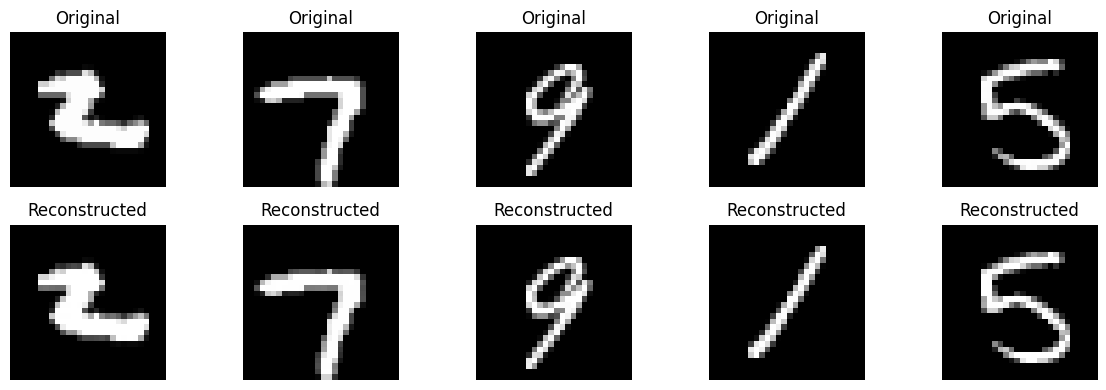

Final Compression Rate Score: 1159383911132812.5
Information Original: [1294.0760498046875, 1279.6934814453125, 1175.191162109375, 796.7808837890625, 1225.96728515625, 1403.5631103515625, 1340.560546875, 1185.807373046875, 1235.964111328125, 1233.3953857421875, 1421.6075439453125, 1405.1065673828125, 1793.5589599609375, 1336.501708984375, 1369.568603515625, 1302.643310546875, 1353.142822265625, 1659.699951171875, 1531.0208740234375, 900.109375, 1361.956298828125, 1178.043212890625, 1440.0474853515625, 1105.3349609375, 1076.7509765625, 1207.27783203125, 1135.9554443359375, 1239.6510009765625, 648.509765625, 1007.117919921875, 1261.59375, 1357.61962890625, 1307.2406005859375, 1447.1395263671875, 1266.7640380859375, 1298.8359375, 1139.700439453125, 1240.042724609375, 1488.1082763671875, 829.171142578125, 1074.747314453125, 1348.5721435546875, 1268.768798828125, 1224.9388427734375, 848.0123291015625, 1166.7662353515625, 1546.7923583984375, 1938.539306640625, 1186.8939208984375, 715.3945922

In [99]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Define the encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 32, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 64, 7, 7]
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

    def forward(self, x):
        z = self.encoder(x)
        return z


# Define the decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 64, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 32, 28, 28]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),  # [batch_size, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.decoder(z)
        return x


# Combine encoder and decoder into an autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed


# Define a class to calculate encoder non-zero dimensions and information captured
class AutoencoderEvaluator:
    def __init__(self, alpha, M):
        # the final return is:
        # captured information * alpha + compression_rate
        # We may keep alpha = 0 for just focus on compression rate
        self.alpha = alpha
        self.M = M

    #we may or may not use this func !!!!!
    def count_non_zero_dimensions(self, encoder_output):
        # Count non-zero values in each (num_filter, h, w) tensor along the channel axis
        batch_size = encoder_output.shape[0]
        non_zero_count = []
        zero_count = []
        for i in range(batch_size):
            non_zero_dims = torch.sum(encoder_output[i] != 0, dim=(1, 2))  # Count non-zero values for each channel (dim 1)
            total_non_zero = torch.sum(non_zero_dims)  # Sum across all channels to get total non-zero values
            total_zero = encoder_output[i].numel() - total_non_zero  # Total elements minus non-zero elements
            non_zero_count.append(total_non_zero.item())
            zero_count.append(total_zero.item())
        return non_zero_count, zero_count


    def calculate_information(self, encoder_output, num_bins=32):
        """
        Calculate the amount of information required to describe a one-channel image pixel by pixel and store the probability distribution.

        Args:
            encoder_output (torch.Tensor): The output of the encoder with shape (batch_size, num_filters, h', w').
            num_bins (int): The number of quantized levels (default is 32).

        Returns:
            information_list (list): A list where each element is the total information for a batch sample.
            probability_distributions (dict): A dictionary storing the probability distribution for each pixel.
        """
        batch_size, num_filters, h_prime, w_prime = encoder_output.shape

        # Initialize a tensor to store information per pixel for each batch
        pixelwise_information = torch.zeros(batch_size, h_prime, w_prime, device=encoder_output.device)

        # Dictionary to store the probability distributions
        probability_distributions = {}

        for h in range(h_prime):
            for w in range(w_prime):
                # Extract values at the same spatial location (h, w) across the batch and all filters
                pixel_values = encoder_output[:, :, h, w].flatten()  # Shape: (batch_size * num_filters,)

                # Scale values to [0, num_bins - 1] and quantize
                quantized_indices = (pixel_values * (num_bins - 1)).round().to(torch.int64)

                # Calculate histogram to get counts of each quantized value
                histogram = torch.bincount(quantized_indices, minlength=num_bins).float()

                # Calculate probabilities for each quantized value
                total_elements = pixel_values.numel()
                probabilities = histogram / total_elements

                # Avoid log(0) by masking zero probabilities
                probabilities[probabilities == 0] = 1e-12

                # Compute -log2(probabilities)
                log_probabilities = -torch.log2(probabilities)

                # Store only the probabilities of values that actually occurred
                pixel_probabilities = {
                    int(value): prob.item()
                    for value, prob in enumerate(probabilities) if histogram[value] > 0
                }
                probability_distributions[(h, w)] = pixel_probabilities

                # Compute information for each batch individually
                for b in range(batch_size):
                    # Quantize pixel values for the current batch and location
                    batch_pixel_values = encoder_output[b, :, h, w].flatten()  # Shape: (num_filters,)
                    batch_quantized_indices = (batch_pixel_values * (num_bins - 1)).round().to(torch.int64)

                    # Calculate the pixel-wise information for this batch
                    batch_histogram = torch.bincount(batch_quantized_indices, minlength=num_bins).float()
                    batch_pixel_information = torch.sum(batch_histogram * log_probabilities)

                    # Assign the information to the corresponding batch and pixel location
                    pixelwise_information[b, h, w] = batch_pixel_information

        # Sum over all pixels to get total information for each batch sample
        total_information_per_sample = pixelwise_information.sum(dim=(1, 2)).tolist()

        return total_information_per_sample, probability_distributions



    def evaluate_batch(self, encoder_output, original_images, reconstructed_images):
        """
        Compute the information compression rate of the autoencoder.

        Args:
            encoder_output (torch.Tensor): Encoder output with shape (batch_size, num_filters, h', w').
            original_images (torch.Tensor): Original images with shape (batch_size, 1, H, W).
            reconstructed_images (torch.Tensor): Reconstructed images with shape (batch_size, 1, H, W).

        Returns:
            float: The final compression rate score.
        """

        # Threshold residual image values
        #reconstructed_images[reconstructed_images <= 0.04] = 0.
        #reconstructed_images[reconstructed_images >= 0.96] = 1.

        # Calculate information in original images
        information_original, Dict_original = self.calculate_information(original_images, num_bins=256)

        # Calculate information in encoder output
        #information_encoder = self.calculate_information(encoder_output, num_bins=32)
        information_encoder = [0,0,0]

        # Compute residual images
        residual_images = original_images - reconstructed_images

        # Normalize residual images to range [0, 1]
        residual_images = (residual_images + 1) / 2

        # Calculate information in residual images
        information_residual, Dict_residual = self.calculate_information(residual_images, num_bins=512)

        # Calculate information obtained by reconstruction
        information_reconstruct = [max(0, orig - resid) for orig, resid in zip(information_original, information_residual)]

        # Calculate compression rate for each batch
        compress_batch = [reconstruct / (encoder + 1e-12) for reconstruct, encoder in zip(information_reconstruct, information_encoder)]

        # Sort and take the top M compression rates
        top_compression_rates = sorted(compress_batch, reverse=True)[:self.M]

        # Return the final compression rate score
        final_score = sum(top_compression_rates)
        return final_score, information_original, information_residual, information_reconstruct, information_encoder, Dict_residual


# Function to load the autoencoder and evaluate
def load_and_evaluate_autoencoder(pth_path, batch_size=10, 
                                  dataset_path='../../data/MNIST/', 
                                  alpha=0):
    """
    Load a saved autoencoder model and evaluate it using the provided evaluation function.

    Args:
        pth_path (str): Path to the .pth file containing the autoencoder.
        batch_size (int): Batch size for evaluation.
        dataset_path (str): Path to the MNIST dataset.
        alpha (float): Weight for the information captured term in evaluation.
        M (int): Number of top compression rates to consider in evaluation.

    Returns:
        float: Final compression rate score for the autoencoder.
        Additional intermediate metrics: information_original, information_residual, 
        information_reconstruct, information_encoder.
    """
    # Initialize a new Autoencoder instance
    autoencoder = Autoencoder()

    # Load the saved weights
    autoencoder.load_state_dict(torch.load(pth_path))
    #autoencoder = autoencoder.to('cuda')
    autoencoder.eval()  # Set the model to evaluation mode

    # Initialize the evaluator
    M = batch_size
    evaluator = AutoencoderEvaluator(alpha, M)

    # Prepare the MNIST dataset
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root=dataset_path, train=True, download=True, transform=transform)

    # Create DataLoader for sampling
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Sample a batch of images
    sampled_images, _ = next(iter(data_loader))
    sampled_images_gpu = sampled_images.to('cuda')

    # Perform forward pass
    with torch.no_grad():
        encoder_output = autoencoder.encoder(sampled_images)  # Get encoder output
        reconstructed_images = autoencoder(sampled_images)    # Get reconstructed images
        encoder_output = encoder_output.cpu()
        reconstructed_images = reconstructed_images.cpu()

    #print(reconstructed_images)

    # Evaluate the autoencoder
    final_score, info_original, info_residual, info_reconstruct, info_encoder, Dict_residual = evaluator.evaluate_batch(
        encoder_output, sampled_images, reconstructed_images
    )

    # Plot some original and reconstructed images
    num_images_to_plot = min(5, batch_size)
    fig, axes = plt.subplots(2, num_images_to_plot, figsize=(12, 4))
    for i in range(num_images_to_plot):
        # Original image
        axes[0, i].imshow(sampled_images[i].squeeze().numpy(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Reconstructed image
        axes[1, i].imshow(reconstructed_images[i].squeeze().numpy(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

    return final_score, info_original, info_residual, info_reconstruct, info_encoder, Dict_residual

# Example usage
if __name__ == "__main__":
    pth_path = "../../model_bin/main_1.1_Nov_15_2024/autoencoder.pth"
    batch_size = 1000

    # Load and evaluate
    final_score, info_original, info_residual, info_reconstruct, info_encoder, Dict_residual = load_and_evaluate_autoencoder(pth_path, batch_size)

    print("Final Compression Rate Score:", final_score)
    print("Information Original:", info_original)
    print("Information Residual:", info_residual)
    print("Information Reconstruct:", info_reconstruct)
    print("Information Encoder:", info_encoder)


In [100]:
Dict_residual

{(0, 0): {255: 1.0},
 (0, 1): {255: 1.0},
 (0, 2): {255: 1.0},
 (0, 3): {255: 1.0},
 (0, 4): {255: 1.0},
 (0, 5): {255: 1.0},
 (0, 6): {255: 1.0},
 (0, 7): {255: 1.0},
 (0, 8): {255: 1.0},
 (0, 9): {255: 1.0},
 (0, 10): {255: 1.0},
 (0, 11): {254: 0.0010000000474974513, 255: 0.9990000128746033},
 (0, 12): {253: 0.0010000000474974513, 255: 0.9990000128746033},
 (0, 13): {255: 1.0},
 (0, 14): {255: 1.0},
 (0, 15): {255: 1.0},
 (0, 16): {253: 0.0020000000949949026, 255: 0.9980000257492065},
 (0, 17): {255: 1.0},
 (0, 18): {255: 1.0},
 (0, 19): {255: 1.0},
 (0, 20): {255: 1.0},
 (0, 21): {255: 1.0},
 (0, 22): {255: 1.0},
 (0, 23): {255: 1.0},
 (0, 24): {255: 1.0},
 (0, 25): {255: 1.0},
 (0, 26): {255: 1.0},
 (0, 27): {255: 1.0},
 (1, 0): {255: 1.0},
 (1, 1): {256: 1.0},
 (1, 2): {255: 0.9909999966621399, 256: 0.008999999612569809},
 (1, 3): {255: 1.0},
 (1, 4): {255: 1.0},
 (1, 5): {255: 1.0},
 (1, 6): {255: 1.0},
 (1, 7): {255: 1.0},
 (1, 8): {250: 0.0010000000474974513, 255: 0.9990000128

/tmp/ipykernel_19092/1004806945.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder = torch.load(pth_path)


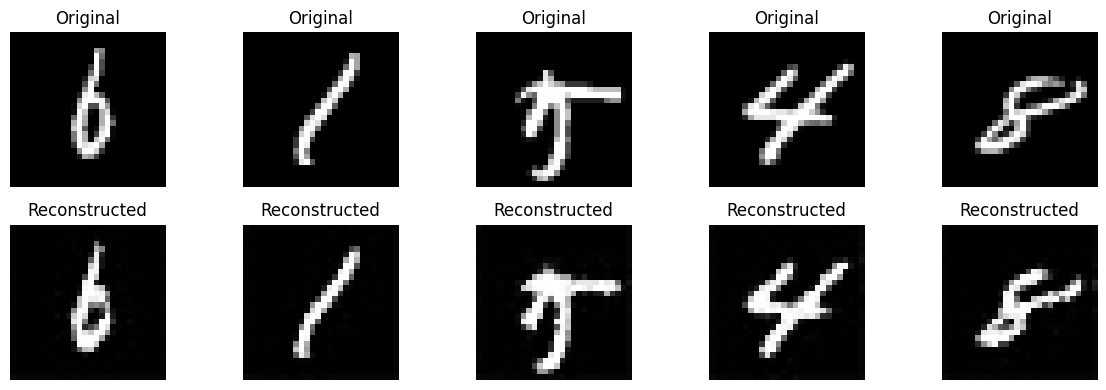

In [47]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader




class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 32, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 32, 7, 7]
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

    def quantize(self, z):
        # Quantization to 32 levels between 0 and 1
        z = torch.clamp(z, 0, 1)  # Ensure the values are between 0 and 1
        z_quantized = torch.round(z * 31) / 31  # Scale to 31, round, then scale back to [0, 1]
        return z_quantized

    def forward(self, x):
        z = self.encoder(x)
        z_quantized = self.quantize(z)
        return z_quantized


# Define the decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 64, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 32, 28, 28]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),  # [batch_size, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.decoder(z)
        return x


# Combine encoder and decoder into an autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed




batch_size = 10
pth_path = "../../model_bin/test_2_main_1_Nov_29_2024/optimal_autoencoder_model_epoch_14.pth"

# Initialize a new Autoencoder instance
autoencoder = Autoencoder()

# Load the saved weights
autoencoder = torch.load(pth_path)
autoencoder = autoencoder.to('cuda')
autoencoder.eval()  # Set the model to evaluation mode

# Prepare the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='../../data/MNIST/', train=True, download=True, transform=transform)

# Create DataLoader for sampling
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Sample a batch of images
sampled_images, _ = next(iter(data_loader))
sampled_images_gpu = sampled_images.to('cuda')

# Perform forward pass
with torch.no_grad():
    encoder_output = autoencoder.encoder(sampled_images_gpu)  # Get encoder output
    reconstructed_images = autoencoder(sampled_images_gpu)    # Get reconstructed images
    encoder_output = encoder_output.cpu()
    reconstructed_images = reconstructed_images.cpu()

# Plot some original and reconstructed images
num_images_to_plot = min(5, batch_size)
fig, axes = plt.subplots(2, num_images_to_plot, figsize=(12, 4))
for i in range(num_images_to_plot):
    # Original image
    axes[0, i].imshow(sampled_images[i].squeeze().numpy(), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # Reconstructed image
    axes[1, i].imshow(reconstructed_images[i].squeeze().numpy(), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

/tmp/ipykernel_19092/1833417653.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(pth_path))


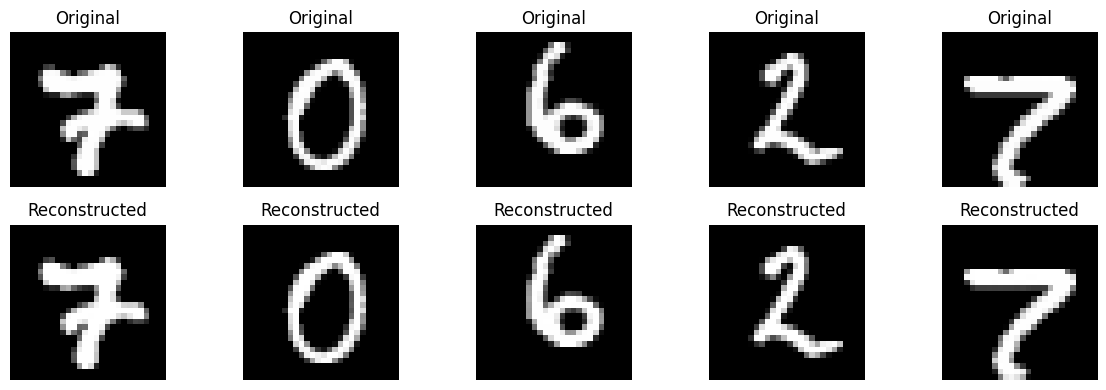

In [50]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Define the encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 32, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # Output: [batch_size, 64, 7, 7]
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

    def forward(self, x):
        z = self.encoder(x)
        return z


# Define the decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 64, 14, 14]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 32, 28, 28]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),  # [batch_size, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.decoder(z)
        return x


# Combine encoder and decoder into an autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed




batch_size = 10
pth_path = "../../model_bin/main_1.1_Nov_15_2024/autoencoder.pth"

# Initialize a new Autoencoder instance
autoencoder = Autoencoder()

# Load the saved weights
autoencoder.load_state_dict(torch.load(pth_path))
#autoencoder = autoencoder.to('cuda')
autoencoder.eval()  # Set the model to evaluation mode

# Prepare the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='../../data/MNIST/', train=True, download=True, transform=transform)

# Create DataLoader for sampling
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Sample a batch of images
sampled_images, _ = next(iter(data_loader))
sampled_images_gpu = sampled_images.to('cuda')

# Perform forward pass
with torch.no_grad():
    encoder_output = autoencoder.encoder(sampled_images)  # Get encoder output
    reconstructed_images = autoencoder(sampled_images)    # Get reconstructed images
    encoder_output = encoder_output.cpu()
    reconstructed_images = reconstructed_images.cpu()

# Plot some original and reconstructed images
num_images_to_plot = min(5, batch_size)
fig, axes = plt.subplots(2, num_images_to_plot, figsize=(12, 4))
for i in range(num_images_to_plot):
    # Original image
    axes[0, i].imshow(sampled_images[i].squeeze().numpy(), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # Reconstructed image
    axes[1, i].imshow(reconstructed_images[i].squeeze().numpy(), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [32]:
reconstructed_images.shape

torch.Size([10, 1, 28, 28])

In [33]:
sampled_images.shape

torch.Size([10, 1, 28, 28])

In [34]:
type(reconstructed_images)

torch.Tensor

In [51]:
def extract_mnist_image(images, k, flatten=True):  
    """  
    Extract k'th image from a batch of MNIST images and process it.  

    Args:  
        images (torch.Tensor): Tensor of shape [B, 1, 28, 28] containing MNIST images  
        k (int): Index of image to extract (0 to B-1)  
        flatten (bool): If True, return flattened list; if False, return 2D numpy array  

    Returns:  
        If flatten=True: list of 784 elements  
        If flatten=False: numpy array of shape (28, 28)  
    """  
    # Input validation  
    if k >= images.shape[0]:  
        raise ValueError(f"k ({k}) must be less than batch size ({images.shape[0]})")  

    # Extract and convert to numpy  
    numpy_image = images[k, 0].detach().cpu().numpy()  

    if flatten:  
        return numpy_image.flatten().tolist()  
    return numpy_image  

# Example usage:  
# For flattened list:  
l_0 = extract_mnist_image(reconstructed_images, k=0, flatten=True)  
# print(len(flattened_list))  # Should be 784  

# For 2D numpy array:  
l_1 = extract_mnist_image(sampled_images, k=0, flatten=True)  
# print(numpy_2d.shape)  # Should be (28, 28)  

In [52]:
import numpy as np  
from sklearn.metrics import mutual_info_score  
from scipy.stats import entropy  

def calculate_image_information(l_0, l_1):  
    """  
    Calculate mutual information (in bits) between original and reconstructed image lists,  
    and entropy (in bits) of the original image.  

    Args:  
        l_0 (list): Flattened list of original image (784 elements)  
        l_1 (list): Flattened list of reconstructed image (784 elements)  

    Returns:  
        dict: Contains mutual information and entropy values (all in bits)  
    """  
    # Convert lists to numpy arrays if they aren't already  
    arr_0 = np.array(l_0)  
    arr_1 = np.array(l_1)  

    # Discretize the values if they're continuous  
    bins = 256  
    arr_0_binned = np.floor(arr_0 * bins).astype(int)  
    arr_1_binned = np.floor(arr_1 * bins).astype(int)  

    # Calculate mutual information  
    # Convert from nats to bits by dividing by ln(2)  
    mi = mutual_info_score(arr_0_binned, arr_1_binned) / np.log(2)  

    # Calculate entropy of original image  
    hist_0, _ = np.histogram(arr_0, bins=bins, density=True)  
    hist_0 = hist_0[hist_0 > 0]  # Remove zeros to avoid log(0)  
    ent = entropy(hist_0, base=2)  # Already in bits  

    # Calculate information retention ratio  
    retention_ratio = mi / ent if ent != 0 else 0  

    return {  
        'mutual_information': mi,  
        'entropy': ent,  
        'retention_ratio': retention_ratio  
    }  

def analyze_reconstruction(l_0, l_1):  
    """  
    Analyze and print the information metrics between original and reconstructed images.  
    All values are in bits.  
    """  
    results = calculate_image_information(l_0, l_1)  

    print(f"Original Image Entropy: {results['entropy']:.2f} bits")  
    print(f"Mutual Information: {results['mutual_information']:.2f} bits")  
    print(f"Information Retention Ratio: {results['retention_ratio']:.2%}")  

    return results  

# Example usage:  
results = analyze_reconstruction(l_0, l_1)  

Original Image Entropy: 1.87 bits
Mutual Information: 1.77 bits
Information Retention Ratio: 94.83%
